# Energy Suppliers on Trustpilot - simple ML models

Author: Stefanie Arlt

## Outline

There are two data sets available, both containing information scraped from the Trustpilot web site:

 - 1: Trustpilot Energy supplier rankings in Germany (https://de.trustpilot.com/categories/electric_utility_company)

 - 2: Trustpilot Comments and feedback to energy suppliers in Germany (see comment column in import data for links)

This notebook focuses on the 2nd file with the aim to apply simple machine learning models.

Idea: Rating prediction based on number of words in customer feedback --> Stefanie

 - check for improvement with number of words in supplier response
 - additional feature supplier name and using complete data set 2
 - only using data from one supplier
 - check results for support vector machine SVC, decision tree classifier

Idea 2: Prediction of number of words of response based on number of words in customer feedback and star rating --> Matthias


## Prepare data set

### Import

In [9]:
# basic import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [10]:
# import data
all_data = pd.read_csv("all_suppliers_data_processed.csv", index_col=0)
all_data.head()

,Nickname,Location,Stars,Headline,DoP,DoE,Comment,Answer,DoA,DoE.day,...,DoA.day,DoA.month,DoA.year,Comment_TF,Answer_TF,Company,Words_Headline,Words_Comment,Words_Answer,Response_time
0,Paul,DE,5,Seriös und preiswert:,2023-08-29 15:00:29+00:00,2023-08-29,Seriös und preiswert:nach einer ziemlich unang...,NaN,NaN,29,...,NaN,NaN,NaN,1,0,Octopus Energy Germany,3,62.0,NaN,NaN
1,Anton,DE,5,Tarif mit vernünftigem Preis,2023-08-30 11:20:02+00:00,2023-08-22,Tarif mit vernünftigem Preis bei niedrigem Ein...,NaN,NaN,22,...,NaN,NaN,NaN,1,0,Octopus Energy Germany,4,41.0,NaN,NaN
2,Tobias,DE,5,Ringo Star,2023-08-29 10:00:40+00:00,2023-08-21,"Supi Anbieterwechsel,klappt alles mit dem vora...",NaN,NaN,21,...,NaN,NaN,NaN,1,0,Octopus Energy Germany,2,37.0,NaN,NaN
3,Dirk Meinel,DE,5,Schritt für Schritt transparent,2023-08-30 09:18:07+00:00,2023-08-27,Erstmalig habe ich mich bei Octopus Engergy an...,NaN,NaN,27,...,NaN,NaN,NaN,1,0,Octopus Energy Germany,4,41.0,NaN,NaN
4,Marianne Bäßler,DE,5,HOHE ZUFRIEDENHEIT,2023-08-29 17:30:02+00:00,2023-08-29,HOHE ZUFRIEDENHEIT BEIM NEUEN ANBIETER OCTOPU...,NaN,NaN,29,...,NaN,NaN,NaN,1,0,Octopus Energy Germany,2,70.0,NaN,NaN


#### Column description:

Scraped data:
 - Customer nickname	“Nickname"
 - Location of customer	”Location"
 - Star rating of customer	“Stars”
 - Headline of post	“Headline"
 - Date of post	“DoP"
 - Date of experience	“DoE"
 - Comment of customer	“Comment"
 - Answer of energy supplier	“Answer”
 - Date of answer	“DoA”	if, and only if answer exists
 - Company name, i.e. energy supplier)	“Company”

Engineered features:
 - Splits of DoP, DoE, DoA into day, month, year	“DoP.day”, “DoP.month”, …
 - Is there a comment? (value: 1 or 0)	“Comment_TF”
 - Is there an answer? (value: 1 or 0)	“Answer_TF”
 - Number of words of headline	“Words_Headline”
 - Number of words of comment	“Words_Comment”
 - Number of words of answer	“Words_Answer”
 - Response time of energy supplier to review in days (DoA-DoP)	“Response_time”



In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45135 entries, 0 to 45134
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Nickname        45133 non-null  object 
 1   Location        45135 non-null  object 
 2   Stars           45135 non-null  int64  
 3   Headline        45135 non-null  object 
 4   DoP             45135 non-null  object 
 5   DoE             45135 non-null  object 
 6   Comment         38896 non-null  object 
 7   Answer          28533 non-null  object 
 8   DoA             28533 non-null  object 
 9   DoE.day         45135 non-null  int64  
 10  DoE.month       45135 non-null  int64  
 11  DoE.year        45135 non-null  int64  
 12  DoP.day         45135 non-null  int64  
 13  DoP.month       45135 non-null  int64  
 14  DoP.year        45135 non-null  int64  
 15  DoA.day         28533 non-null  float64
 16  DoA.month       28533 non-null  float64
 17  DoA.year        28533 non-null  floa

In [13]:
all_data.describe()

,Stars,DoE.day,DoE.month,DoE.year,DoP.day,DoP.month,DoP.year,DoA.day,DoA.month,DoA.year,Comment_TF,Answer_TF,Words_Headline,Words_Comment,Words_Answer,Response_time
count,45135.000000,45135.000000,45135.000000,45135.000000,45135.000000,45135.000000,45135.000000,28533.000000,28533.000000,28533.000000,45135.000000,45135.00000,45135.000000,38896.000000,28533.000000,28533.000000
mean,3.746693,15.961560,6.156132,2022.111510,15.834940,6.207134,2022.125224,15.502190,6.203589,2022.511268,0.861770,0.63217,3.989631,38.994832,45.821225,3.578729
std,1.710561,9.247217,3.182604,1.411342,9.203304,3.151267,1.413024,9.053061,2.942557,1.031836,0.345145,0.48222,2.229505,58.044166,36.309001,30.965186
min,1.000000,1.000000,1.000000,2011.000000,1.000000,1.000000,2011.000000,1.000000,1.000000,2012.000000,0.000000,0.00000,1.000000,1.000000,1.000000,-1008.294262
25%,1.000000,8.000000,4.000000,2022.000000,8.000000,4.000000,2022.000000,8.000000,4.000000,2022.000000,1.000000,0.00000,2.000000,9.000000,18.000000,0.249907
50%,5.000000,16.000000,6.000000,2023.000000,16.000000,7.000000,2023.000000,16.000000,7.000000,2023.000000,1.000000,1.00000,4.000000,19.000000,38.000000,0.744954
75%,5.000000,24.000000,8.000000,2023.000000,24.000000,8.000000,2023.000000,23.000000,8.000000,2023.000000,1.000000,1.00000,5.000000,45.000000,54.000000,1.980070
max,5.000000,31.000000,12.000000,2023.000000,31.000000,12.000000,2023.000000,31.000000,12.000000,2023.000000,1.000000,1.00000,60.000000,1469.000000,555.000000,1376.952442


### Data set selection and exploration

#### select relevant data

In [16]:
#select only data with answers present
answers = all_data.loc[all_data['Answer_TF'] == 1]
answers.head()

,Nickname,Location,Stars,Headline,DoP,DoE,Comment,Answer,DoA,DoE.day,...,DoA.day,DoA.month,DoA.year,Comment_TF,Answer_TF,Company,Words_Headline,Words_Comment,Words_Answer,Response_time
20,Georgio,DE,1,Schlechter Service bei Anfragen per Mail,2023-08-30 03:25:20+00:00,2023-08-02,Wichtige Anfragen / Änderungen per Mail vom 02...,"Hallo Jörg, vielen Dank für deine Zeit in der ...",2023-08-30 12:09:55+00:00,2,...,30.0,8.0,2023.0,1,1,Octopus Energy Germany,6,38.0,45.0,0.364294
22,Thomas Wilhelm,GR,1,ungefragt Duzen und Gendersprache!,2023-08-29 11:45:41+00:00,2023-08-21,ich habe es schon bereut diesen Anbieter gewäh...,"Hallo Thomas, vielen Dank für deine Zeit, die ...",2023-08-30 12:10:22+00:00,21,...,30.0,8.0,2023.0,1,1,Octopus Energy Germany,4,45.0,50.0,1.017141
40,Kirsten,DE,4,Willkommen,2023-08-29 10:08:03+00:00,2023-08-04,Der Wechsel war sehr einfach und verlief probl...,"Hallo Kirsten,vielen Dank für deine gute Bewer...",2023-08-30 06:14:11+00:00,4,...,30.0,8.0,2023.0,1,1,Octopus Energy Germany,1,22.0,24.0,0.837593
41,Thomas,DE,4,Der Anbieterwechsel klappt super,2023-08-29 15:53:18+00:00,2023-08-21,Der Anbieterwechsel (Papierkram) hat super gek...,"Hallo Thomas,danke dir vielmals für die gute B...",2023-08-30 06:13:16+00:00,21,...,30.0,8.0,2023.0,1,1,Octopus Energy Germany,4,19.0,12.0,0.597199
49,Heiko,DE,4,Bis jetzt war alles zufriedenstellend,2023-08-29 08:26:24+00:00,2023-08-21,Bis jetzt war alles zufriedenstellend Vom Erst...,"Hallo Heiko,vielen Dank für deine gute Bewertu...",2023-08-30 06:15:27+00:00,21,...,30.0,8.0,2023.0,1,1,Octopus Energy Germany,5,27.0,24.0,0.909062


In [17]:
column_names = answers.columns
print(column_names)

Index(['Nickname', 'Location', 'Stars', 'Headline', 'DoP', 'DoE', 'Comment',
       'Answer', 'DoA', 'DoE.day', 'DoE.month', 'DoE.year', 'DoP.day',
       'DoP.month', 'DoP.year', 'DoA.day', 'DoA.month', 'DoA.year',
       'Comment_TF', 'Answer_TF', 'Company', 'Words_Headline', 'Words_Comment',
       'Words_Answer', 'Response_time'],
      dtype='object')


In [18]:
# reduce features, so we keep 'Stars' as target
# and drop all columns except 'Company', 'Words_Headline', 'Words_Comment', 'Words_Answer', 'Response_time'

star1 = answers.drop(['Nickname', 'Location', 'Headline', 'DoP', 'DoE', 'Comment', 'Words_Answer', 'Response_time', 
       'Answer', 'DoA', 'DoE.day', 'DoE.month', 'DoE.year', 'DoP.day',
       'DoP.month', 'DoP.year', 'DoA.day', 'DoA.month', 'DoA.year',
       'Comment_TF', 'Answer_TF'], axis=1)
star1.head()

,Stars,Company,Words_Headline,Words_Comment
20,1,Octopus Energy Germany,6,38.0
22,1,Octopus Energy Germany,4,45.0
40,4,Octopus Energy Germany,1,22.0
41,4,Octopus Energy Germany,4,19.0
49,4,Octopus Energy Germany,5,27.0


In [19]:
star1.info()
# there are missing values

<class 'pandas.core.frame.DataFrame'>
Index: 28533 entries, 20 to 45132
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Stars           28533 non-null  int64  
 1   Company         28533 non-null  object 
 2   Words_Headline  28533 non-null  int64  
 3   Words_Comment   25046 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.1+ MB


There are missing values: 

12% of the data does have no entry in Words_comment, because only headline is a mandatory field for a customer feedback.
 - we could delete all rows with no answer
 - or we replace NaN with 0, because it is interesting that some users did not even bother to leave an explanation with their headline. As we can see from the target distribution, nearly all customer posts with 0 words have a 5 star rating.
 

In [21]:
#replace NaN with 0 for selected columns:
for column in ['Words_Comment']:
    star1[column].fillna(0, inplace=True)

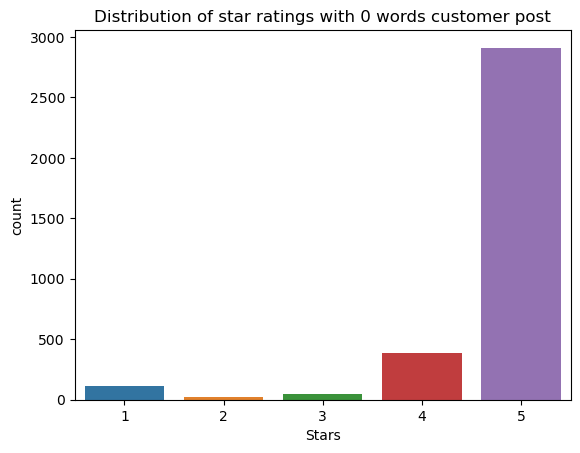

In [22]:
#plot distribution
plt.title("Distribution of star ratings with 0 words customer post")
sns.countplot(x='Stars', data=star1[star1['Words_Comment'] == 0]); 

In [23]:
# change dtype
star1['Words_Comment']=star1.Words_Comment.astype('int64')

star1.info() # no more NaN

<class 'pandas.core.frame.DataFrame'>
Index: 28533 entries, 20 to 45132
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Stars           28533 non-null  int64 
 1   Company         28533 non-null  object
 2   Words_Headline  28533 non-null  int64 
 3   Words_Comment   28533 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [24]:
star1.isna().sum().sum()

0

In [25]:
star1.describe()

,Stars,Words_Headline,Words_Comment
count,28533.000000,28533.000000,28533.000000
mean,3.538534,4.051379,37.408229
std,1.776946,2.265859,58.475650
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,7.000000
50%,5.000000,4.000000,17.000000
75%,5.000000,5.000000,45.000000
max,5.000000,43.000000,1469.000000


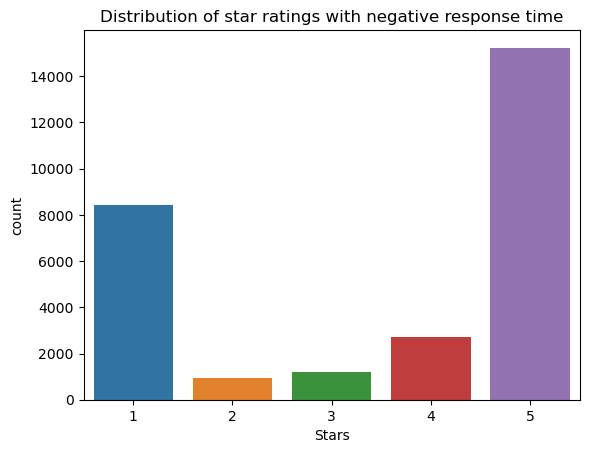

In [26]:
#plot distribution
plt.title("Distribution of star ratings with negative response time")
sns.countplot(x='Stars', data=star1);


In [27]:
#reset index
star1.reset_index(drop=True, inplace=True) #drop=True - no new ID column inserted

### Target Information

In [29]:
#unique values of 'Stars' in percentage
star1['Stars'].value_counts()

Stars
5    15231
1     8444
4     2729
3     1192
2      937
Name: count, dtype: int64

In [30]:
# target information: un-balanced data set
#unique values of 'Stars' in percentage
star1['Stars'].value_counts(normalize=True)


Stars
5    0.533803
1    0.295938
4    0.095644
3    0.041776
2    0.032839
Name: proportion, dtype: float64

The target variable 'Stars' is not evenly distributed in the data-set:
 - Over 50% of the customer comments are 5-star ratings, 
 - followed by around 30% of 1-star ratings and around 10% of 4-star labels. 
 - Less than 5% each go to 3- and 2-star ratings.

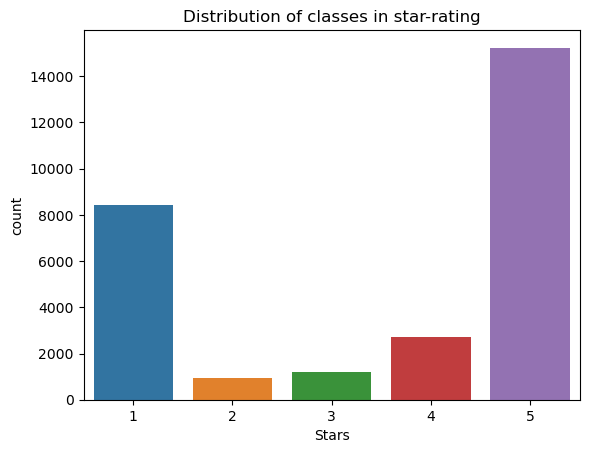

In [32]:
#plot distribution
plt.title("Distribution of classes in star-rating")
sns.countplot(x='Stars', data=star1);


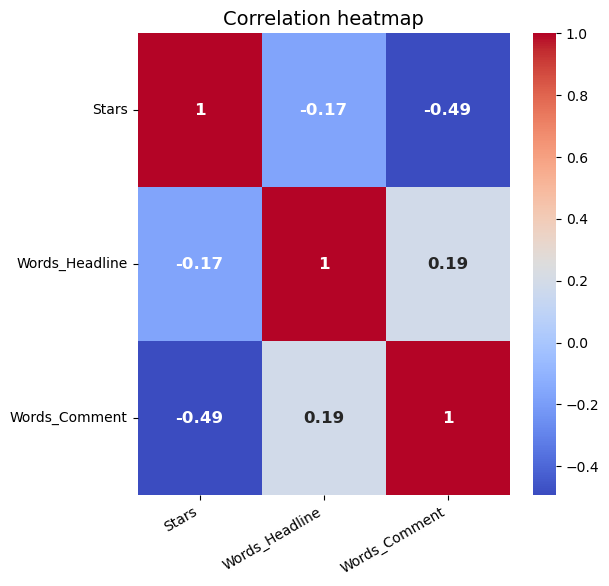

In [33]:
#check correlation of features with heatmap
# select data
cor_data = star1.drop(['Company'], axis=1)

cor = cor_data.corr()

#Heatmap
f, ax = plt.subplots(figsize = (6,6))
sns.heatmap(cor, annot= True, ax=ax, cmap= 'coolwarm', annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Correlation heatmap', fontsize= 14 )
plt.xticks(rotation= 30, ha='right')
plt.yticks(rotation = 0)
plt.xticks(fontsize= 10)
plt.yticks(fontsize=10)
plt.show();


# Interpretation:
# Red colors indicate a high positive correlation between the variables.
# Blue colors show a poor and even negative correlation correlation.

### Treatment of Outliers

In the distribution of our main variables, there are a few data points which have extreme values. In order to identify the outliers we have to decide first, if we have a normal distribution or not:

 - In case of standard distribution (KDE plot): Anything outside of 3 standard deviations can be considered as outlier.
 - In case of a skewed distribution (box plot) we look at the inter-quartile range (IQR): Data points below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR can be considered as outliers.

Link: Dey, Akash: How to handle outliers, Feb 2022: https://www.kaggle.com/code/aimack/how-to-handle-outliers/notebook

#### Words_Headline

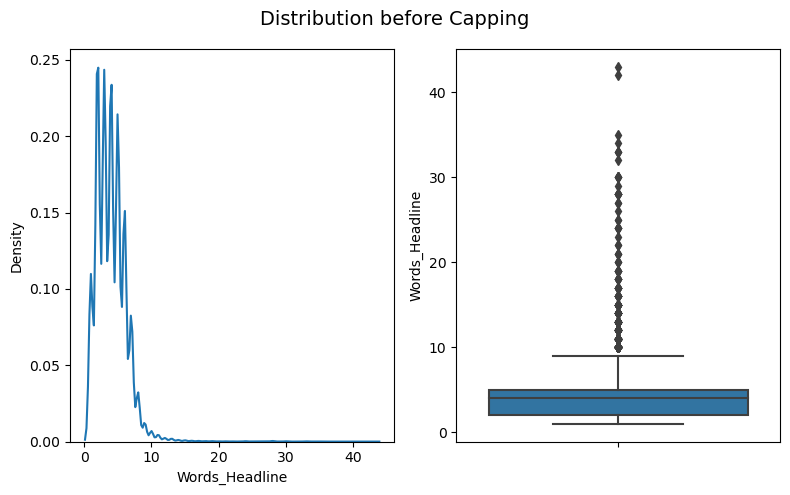

In [37]:

#plot distribution before Capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution before Capping", fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x= 'Words_Headline', data = star1)
plt.subplot(1,2,2)
sns.boxplot(y= 'Words_Headline', data = star1)
plt.tight_layout()
plt.show()

In [38]:
#Finding the Q1(25% percentile) and Q3(75% percentile)
s_q1 = star1["Words_Headline"].quantile(0.25)
s_q3 = star1["Words_Headline"].quantile(0.75)
print("For 'Words_Headline': Q1(25% percentile) equals ", s_q1, " and Q3(75% percentile) equals ", s_q3)

#Finding out the value of the Inter Quartile Range
s_IQR = s_q3 - s_q1
print("For 'Words_Headline': IQR equals ", round(s_IQR, 3))

#Defining max and min limits
s_max_limit = s_q3 + (1.5 * s_IQR)
s_min_limit = s_q1 - (1.5 * s_IQR) 
print("For 'Words_Headline': max limit equals ", round(s_max_limit, 0)) # word count is integer, round to 0 digits
print("For 'Words_Headline': min limit equals ", round(s_min_limit, 0))


For 'Words_Headline': Q1(25% percentile) equals  2.0  and Q3(75% percentile) equals  5.0
For 'Words_Headline': IQR equals  3.0
For 'Words_Headline': max limit equals  10.0
For 'Words_Headline': min limit equals  -2.0


In [39]:
## Identifkation of extreme values for 'Words_Headline'
# some data points are above the max limit (upper whisker) of upper quartile
# max limit calculated as 9.5, rounded to 10
star1.query("Words_Headline >10") # 295 rows

,Stars,Company,Words_Headline,Words_Comment
832,5,Octopus Energy Germany,11,23
2471,5,Octopus Energy Germany,12,70
2485,5,Octopus Energy Germany,28,6
2966,4,Octopus Energy Germany,12,24
3112,5,Octopus Energy Germany,12,9
...,...,...,...,...
28371,3,EWE,13,218
28487,4,EWE,13,20
28500,1,EWE,14,2
28501,1,EWE,16,69


In [40]:
#capping and storing the values into a new df
headline_new = pd.DataFrame(np.where(star1["Words_Headline"] > s_max_limit, np.round(s_max_limit, 0), 
         (np.where(star1["Words_Headline"] < s_min_limit, np.round(s_min_limit, 0), star1["Words_Headline"]))
                                    ), columns=["Words_Headline_new"])

headline_new.head()

,Words_Headline_new
0,6.0
1,4.0
2,1.0
3,4.0
4,5.0


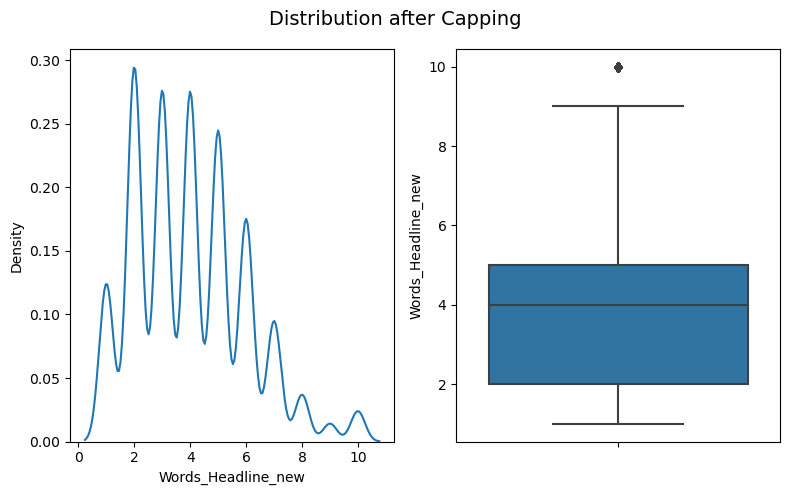

In [41]:
#plot after capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution after Capping",fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x='Words_Headline_new', data = headline_new)
plt.subplot(1,2,2)
sns.boxplot(y='Words_Headline_new', data = headline_new)
plt.tight_layout()
plt.show()

In [42]:
#perform capping = replace columns
star1['Words_Headline'] = headline_new['Words_Headline_new']

star1.loc[[832]] #show capped value examples

,Stars,Company,Words_Headline,Words_Comment
832,5,Octopus Energy Germany,10.0,23


#### Words_Comment

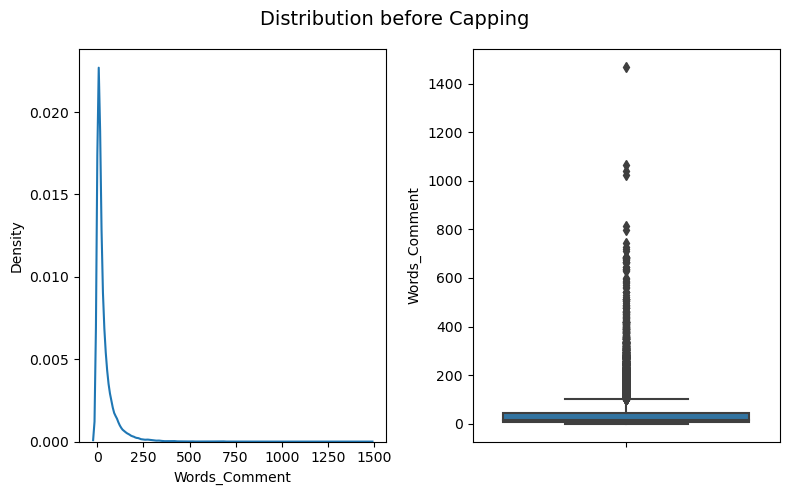

In [44]:
#plot distribution before Capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution before Capping", fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x= 'Words_Comment', data = star1)
plt.subplot(1,2,2)
sns.boxplot(y= 'Words_Comment', data = star1)
plt.tight_layout()
plt.show()

In [45]:
#Finding the Q1(25% percentile) and Q3(75% percentile)
s_q1 = star1["Words_Comment"].quantile(0.25)
s_q3 = star1["Words_Comment"].quantile(0.75)
print("For 'Words_Comment': Q1(25% percentile) equals ", s_q1, " and Q3(75% percentile) equals ", s_q3)

#Finding out the value of the Inter Quartile Range
s_IQR = s_q3 - s_q1
print("For 'Words_Comment': IQR equals ", round(s_IQR, 3))

#Defining max and min limits
s_max_limit = s_q3 + (1.5 * s_IQR)
s_min_limit = s_q1 - (1.5 * s_IQR) 
print("For 'Words_Comment': max limit equals ", round(s_max_limit, 0)) #round to 0 for words
print("For 'Words_Comment': min limit equals ", round(s_min_limit, 0))

For 'Words_Comment': Q1(25% percentile) equals  7.0  and Q3(75% percentile) equals  45.0
For 'Words_Comment': IQR equals  38.0
For 'Words_Comment': max limit equals  102.0
For 'Words_Comment': min limit equals  -50.0


In [46]:
# handling of outliers in Words_Comment
# show outliers
star1[star1['Words_Comment'] > 102] #2542 rows 

,Stars,Company,Words_Headline,Words_Comment
246,3,Octopus Energy Germany,5.0,317
322,4,Octopus Energy Germany,9.0,141
323,1,Octopus Energy Germany,4.0,252
473,3,Octopus Energy Germany,2.0,182
518,1,Octopus Energy Germany,2.0,128
...,...,...,...,...
28477,1,EWE,8.0,129
28479,1,EWE,1.0,158
28494,1,EWE,2.0,331
28518,1,EWE,2.0,109


In [47]:
#capping and storing the values into a new df
comment_new = pd.DataFrame(np.where(star1["Words_Comment"] > s_max_limit, np.round(s_max_limit, 0), 
         (np.where(star1["Words_Comment"] < s_min_limit, np.round(s_min_limit, 0), star1["Words_Comment"]))
                                    ), columns=["Words_Comment_new"])

#comment_new = comment_new.join(star1.Words_Comment)
comment_new.head()

,Words_Comment_new
0,38.0
1,45.0
2,22.0
3,19.0
4,27.0


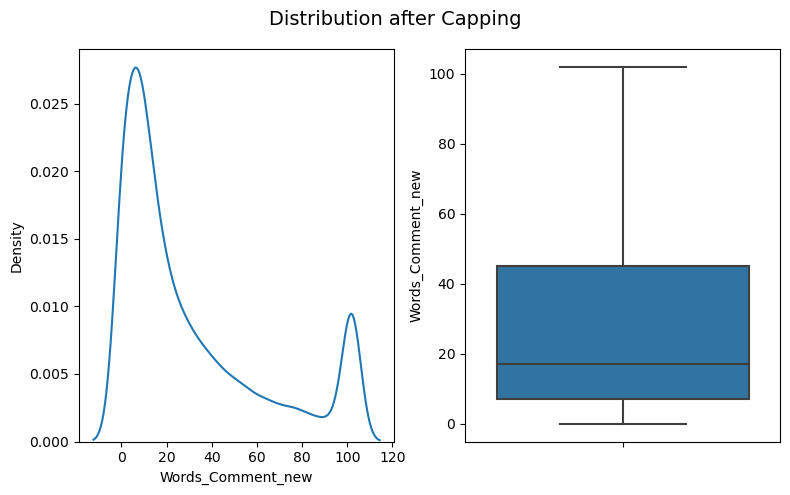

In [48]:
#plot after capping
plt.figure(figsize=(8,5))
plt.suptitle("Distribution after Capping",fontsize=14)
plt.subplot(1,2,1)
sns.kdeplot(x='Words_Comment_new', data = comment_new)
plt.subplot(1,2,2)
sns.boxplot(y='Words_Comment_new', data = comment_new)
plt.tight_layout()
plt.show()

In [49]:
#perform capping = replace columns
star1['Words_Comment'] = comment_new['Words_Comment_new']

star1.loc[[246]] #show capped value examples

,Stars,Company,Words_Headline,Words_Comment
246,3,Octopus Energy Germany,5.0,102.0


#### Distribution of features after capping

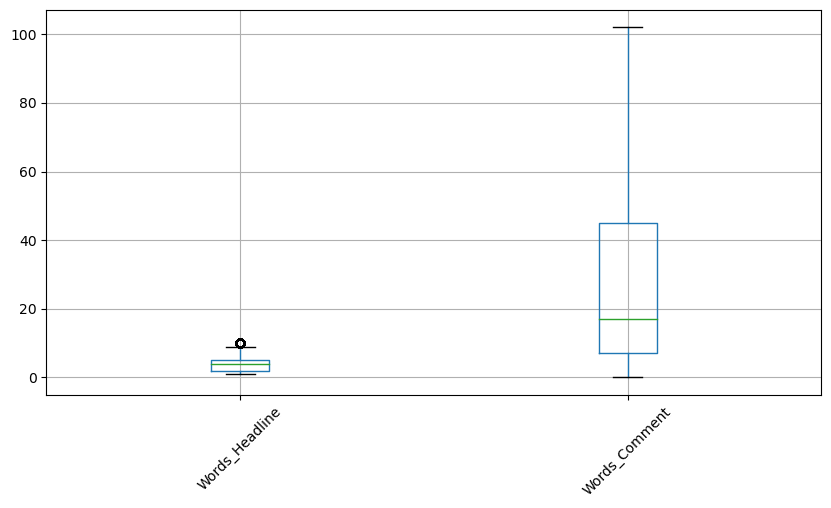

In [51]:
#boxplot of main variables
num_cols = ['Words_Headline', 'Words_Comment']
star1[num_cols].boxplot(figsize = (10,5), rot=45);

### Saving cleaned and capped data set

In [53]:
# Saving the cleaned data frame in a csv file
star1.to_csv("stars_simple_clean.csv", index=False)

### Normalize features

As already seen while handling the outliers, the frames of reference differ from one variable to another and their distribution is not normalized. 

So we need to transform the values by scaling the data to a mean of nearest to 0 and standard deviation of 1.

The boxplot below shows that values of all variables have been scaled to the same magnitude as intended and also transformed to a mean of 0 and standard deviation of 1.

In [56]:
# describe numerical variables
star1.describe()

,Stars,Words_Headline,Words_Comment
count,28533.000000,28533.000000,28533.000000
mean,3.538534,4.001542,30.447692
std,1.776946,1.989897,32.046916
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,7.000000
50%,5.000000,4.000000,17.000000
75%,5.000000,5.000000,45.000000
max,5.000000,10.000000,102.000000


In [57]:
#scale numerical variables
star1_scaled = star1

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

num_cols = ['Words_Headline', 'Words_Comment']
star1_scaled[num_cols]= sc.fit_transform(star1_scaled[num_cols])


In [58]:
# describe numerical variables after scaling
star1_scaled.describe()

,Stars,Words_Headline,Words_Comment
count,28533.000000,2.853300e+04,2.853300e+04
mean,3.538534,7.968797e-18,1.593759e-17
std,1.776946,1.000018e+00,1.000018e+00
min,1.000000,-1.508417e+00,-9.501141e-01
25%,1.000000,-1.005869e+00,-7.316805e-01
50%,5.000000,-7.749651e-04,-4.196325e-01
75%,5.000000,5.017723e-01,4.541018e-01
max,5.000000,3.014509e+00,2.232775e+00


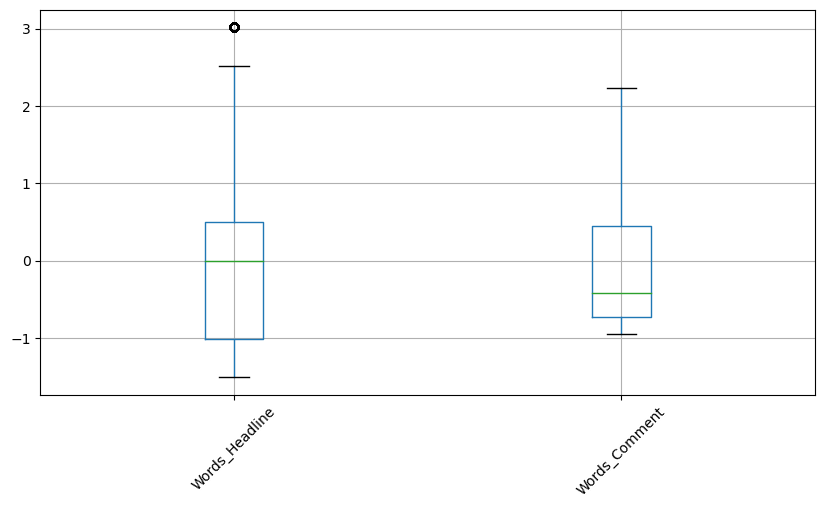

In [59]:
#boxplot of main variables
import matplotlib.pyplot as plt 

star1_scaled[num_cols].boxplot(figsize = (10,5), rot=45);

### Saving normalized data set

In [61]:
# Saving the cleaned data frame in a csv file
star1_scaled.to_csv("stars_simple_scaled_clean.csv", index=False)

### Separate features and target

In [63]:
star1_scaled.head()

,Stars,Company,Words_Headline,Words_Comment
0,1,Octopus Energy Germany,1.004320,0.235668
1,1,Octopus Energy Germany,-0.000775,0.454102
2,4,Octopus Energy Germany,-1.508417,-0.263609
3,4,Octopus Energy Germany,-0.000775,-0.357223
4,4,Octopus Energy Germany,0.501772,-0.107585


In [64]:
star1_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28533 entries, 0 to 28532
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Stars           28533 non-null  int64  
 1   Company         28533 non-null  object 
 2   Words_Headline  28533 non-null  float64
 3   Words_Comment   28533 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 891.8+ KB


In [65]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=star1_scaled['Stars']

feats_simple = star1_scaled.drop(['Stars', 'Company', 'Words_Headline'], axis=1)
feats_simple.head() 

,Words_Comment
0,0.235668
1,0.454102
2,-0.263609
3,-0.357223
4,-0.107585


## SVM Rating prediction based on number of words in customer feedback 

SVM
Suppport vector machine was chosen to work with, because we have limited features and we were looking for a simple but effective model.


---- Note from sklearn documentation ----

Applying support vector machines (SVMs) from scikit-learn package as the first algorithm, which offers the following advantages:

 - Effective in high dimensional spaces.

 - Still effective in cases where number of dimensions is greater than the number of samples. 

 - Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

 - Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.


However, the disadvantages of support vector machines include:

 - If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial. (Not the case for our data set!)

 - SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

Preparation:
 - Standardization
 - only numerical features


Links:

 - User guide support vector machines: https://scikit-learn.org/stable/modules/svm.html; cited as Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
 - Deepthi, A.R.: Support Vector Machines & Imbalanced Data. How does SVM work in the case of an imbalanced dataset?, Medium 2019: https://towardsdatascience.com/support-vector-machines-imbalanced-data-feb3ecffbb0e
 - Sklearn documentation on C support vector classification: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html



Classification Use Case

For adequate response to customer feedback, it is helpful to derive the positive or negative rating from the text and come up with adequate if prepared feedback which is automatically deployed.

The idea to implement with our scraped data set is that we do not have but would like to predict the star rating without information on the sentiment of the supplier response. Is number of words a good indicator?


### Training and Tuning

In [70]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats_simple, target, test_size=0.2, random_state=42)

In [71]:
# import model
from sklearn import svm

In [72]:
# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale'     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
             )
clf.fit(X_train, y_train)

# Accuracy score
print('SVM simple model score test set:', clf.score(X_test, y_test))
print('SVM simple model score train set:', clf.score(X_train, y_train))

SVM simple model score test set: 0.6945855966357105
SVM simple model score train set: 0.6905721545605888


Notes on the model

SVC and NuSVC implement the “one-versus-one” approach for multi-class classification. In total, n_classes * (n_classes - 1) / 2 classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the decision_function_shape option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

On the other hand, LinearSVC implements “one-vs-the-rest” multi-class strategy, thus training n_classes models.

Note that the LinearSVC also implements an alternative multi-class strategy, the so-called multi-class SVM formulated by Crammer and Singer by using the option multi_class='crammer_singer'. In practice, one-vs-rest classification is usually preferred, since the results are mostly similar, but the runtime is significantly less.


In problems where it is desired to give more importance to certain classes or certain individual samples, the parameters class_weight and sample_weight can be used.

SVC (but not NuSVC) implements the parameter class_weight in the fit method. It’s a dictionary of the form {class_label : value}, where value is a floating point number > 0 that sets the parameter C of class class_label to C * value. 

Link: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-unbalanced-py

In [74]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train)  # training set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,1,5
True,,
1,1187,486
2,111,82
3,103,130
4,71,476
5,284,2777


In [75]:
from sklearn.metrics import f1_score, classification_report

# classification report
print("Classification report (simple model):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (simple model):
               precision    recall  f1-score   support

           1       0.68      0.71      0.69      1673
           2       1.00      0.00      0.00       193
           3       1.00      0.00      0.00       233
           4       1.00      0.00      0.00       547
           5       0.70      0.91      0.79      3061

    accuracy                           0.69      5707
   macro avg       0.88      0.32      0.30      5707
weighted avg       0.75      0.69      0.63      5707



In [76]:
# classification report
print("Classification report (simple model):\n", classification_report(y_train, y_pred_train, zero_division=True))

Classification report (simple model):
               precision    recall  f1-score   support

           1       0.66      0.71      0.69      6771
           2       1.00      0.00      0.00       744
           3       1.00      0.00      0.00       959
           4       1.00      0.00      0.00      2182
           5       0.70      0.90      0.79     12170

    accuracy                           0.69     22826
   macro avg       0.87      0.32      0.30     22826
weighted avg       0.74      0.69      0.62     22826



Performance Metrics

As we can see, the standard algorithm cannot match the middle star ratings due to the unbalanced data-set. It only picks very high or very low star ratings. Even with mitigation for class-imbalance, we see a less than random effective way to predict. No overfitting.

We would like to avoid errors caused by false negative and false positives both, as it has direct impact on the other choices
Therefore it makes sense to choose as a metric accuracy and F1 score, combining precision, i.e. correctly classifying positive samples, and recall which measures the model's ability to detect positive samples.



In [78]:
# fit the model and provide for imbalanced data set and multi-class decision
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale',     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
              class_weight='balanced', # to mitigate the imbalanced data set
              decision_function_shape='ovo' # default = one-vs-rest (‘ovr’) decision 
             )
clf.fit(X_train, y_train)

# Accuracy score
print('SVM score test set:', clf.score(X_test, y_test))
print('SVM score train set:', clf.score(X_train, y_train))

SVM score test set: 0.5850709654809882
SVM score train set: 0.5776307719267502


In [79]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train) # test set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,1,2,3,4,5
True,,,,,
1,973,249,230,17,204
2,78,36,30,1,48
3,70,39,50,6,68
4,38,44,101,10,354
5,153,159,417,62,2270


In [80]:
# classification report
print("Classification report with class weight:\n", classification_report(y_test, y_pred))

Classification report with class weight:
               precision    recall  f1-score   support

           1       0.74      0.58      0.65      1673
           2       0.07      0.19      0.10       193
           3       0.06      0.21      0.09       233
           4       0.10      0.02      0.03       547
           5       0.77      0.74      0.76      3061

    accuracy                           0.59      5707
   macro avg       0.35      0.35      0.33      5707
weighted avg       0.65      0.59      0.61      5707



In [81]:
# classification report train set
print("Classification report with class weight training set:\n", classification_report(y_train, y_pred_train))

Classification report with class weight training set:
               precision    recall  f1-score   support

           1       0.72      0.57      0.64      6771
           2       0.05      0.17      0.08       744
           3       0.06      0.21      0.09       959
           4       0.16      0.02      0.04      2182
           5       0.78      0.74      0.76     12170

    accuracy                           0.58     22826
   macro avg       0.35      0.34      0.32     22826
weighted avg       0.65      0.58      0.60     22826



The average accuracy has been reduced to nearly random (0.5), as we now have also some predictions for the less represented classes 2, 3 and 4 - at cost of loosing with the main classes 1 and 5. No overfitting.

We will compare results after using more features.

## SVM Rating prediction based on word count of customer feedback and headline

### Separate features and target

In [85]:
star1_scaled.head()

,Stars,Company,Words_Headline,Words_Comment
0,1,Octopus Energy Germany,1.004320,0.235668
1,1,Octopus Energy Germany,-0.000775,0.454102
2,4,Octopus Energy Germany,-1.508417,-0.263609
3,4,Octopus Energy Germany,-0.000775,-0.357223
4,4,Octopus Energy Germany,0.501772,-0.107585


In [86]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=star1_scaled['Stars']

feats = star1_scaled.drop(['Stars', 'Company'], axis=1)
feats.head() 

,Words_Headline,Words_Comment
0,1.004320,0.235668
1,-0.000775,0.454102
2,-1.508417,-0.263609
3,-0.000775,-0.357223
4,0.501772,-0.107585


### Training and Tuning

In [88]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=42)

In [89]:
# import model
from sklearn import svm

In [90]:
# fit the model and get the separating hyperplane
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale'     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
             )
clf.fit(X_train, y_train)

# Accuracy score
print('SVM score test set:', clf.score(X_test, y_test))
print('SVM score train set:', clf.score(X_train, y_train))


SVM score test set: 0.6958121605046435
SVM score train set: 0.6901778673442566


In [91]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train) # train set

# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,1,5
True,,
1,1171,502
2,105,88
3,102,131
4,70,477
5,261,2800


In [92]:
from sklearn.metrics import f1_score, classification_report

# classification report
print("Classification report (simple model):\n", classification_report(y_test, y_pred, zero_division=True))

Classification report (simple model):
               precision    recall  f1-score   support

           1       0.69      0.70      0.69      1673
           2       1.00      0.00      0.00       193
           3       1.00      0.00      0.00       233
           4       1.00      0.00      0.00       547
           5       0.70      0.91      0.79      3061

    accuracy                           0.70      5707
   macro avg       0.88      0.32      0.30      5707
weighted avg       0.75      0.70      0.63      5707



In [93]:
# classification report train set
print("Classification report (simple model) training set:\n", classification_report(y_train, y_pred_train))

Classification report (simple model) training set:
               precision    recall  f1-score   support

           1       0.67      0.70      0.68      6771
           2       0.00      0.00      0.00       744
           3       0.00      0.00      0.00       959
           4       0.00      0.00      0.00      2182
           5       0.70      0.91      0.79     12170

    accuracy                           0.69     22826
   macro avg       0.27      0.32      0.29     22826
weighted avg       0.57      0.69      0.62     22826



/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Performance Metrics

Also with the additional information from suppliers' answers and response times, the standard algorithm cannot match the middle star ratings due to the unbalanced data-set. It only picks very high or very low star ratings. Even with mitigation for class-imbalance, we see a less than random effective way to predict.

As before, we would like to avoid errors caused by false negative and false positives both, as it has direct impact on the other choices
Therefore it makes sense to choose as a metric accuracy and F1 score, combining precision, i.e. correctly classifying positive samples, and recall which measures the model's ability to detect positive samples.



In [95]:
# fit the model and provide for imbalanced data set and multi-class decision
clf = svm.SVC(kernel="rbf",     # kernel function, default = 'rbf'
              C=1.0,            # Regularization parameter
              gamma='scale',     # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. default = 'scale'
              class_weight='balanced', # to mitigate the imbalanced data set
              decision_function_shape='ovo' # default = one-vs-rest (‘ovr’) decision 
             )
clf.fit(X_train, y_train)

# Accuracy score
print('SVM score:', clf.score(X_test, y_test))
print('SVM score train:', clf.score(X_train, y_train))

SVM score: 0.5395128789206238
SVM score train: 0.5333829843161307


In [96]:
# perform predictions and display confusion matrix
y_pred = clf.predict(X_test) # test set
y_pred_train = clf.predict(X_train) # train set


# Confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predictions'])

Predictions,1,2,3,4,5
True,,,,,
1,994,208,255,43,173
2,80,28,41,6,38
3,71,32,58,10,62
4,39,41,117,66,284
5,177,119,484,348,1933


In [97]:
# classification report
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.73      0.59      0.66      1673
           2       0.07      0.15      0.09       193
           3       0.06      0.25      0.10       233
           4       0.14      0.12      0.13       547
           5       0.78      0.63      0.70      3061

    accuracy                           0.54      5707
   macro avg       0.35      0.35      0.33      5707
weighted avg       0.65      0.54      0.59      5707



In [98]:
# classification report training set
print("Classification report training set:\n", classification_report(y_train, y_pred_train))

Classification report training set:
               precision    recall  f1-score   support

           1       0.71      0.58      0.64      6771
           2       0.06      0.15      0.08       744
           3       0.06      0.24      0.10       959
           4       0.14      0.12      0.13      2182
           5       0.78      0.63      0.70     12170

    accuracy                           0.53     22826
   macro avg       0.35      0.34      0.33     22826
weighted avg       0.65      0.53      0.58     22826



As before, the 1 and 5 star ratings are predicted best. However, we have a small improvement on the middle ratings while dominant classes performed worse than before. No overfitting.

### Undersampling ?

The greater the imbalance between classes, the less successful the classical models will be in predicting the minority class.

Therefore we could apply Oversampling to increase the number of observations of the minority class. However, the focus for a customer service and customer satisfaction KPIs is most likely the extreme opinions: Is the customer really happy or really dissatisfied?. This shows decisive topics for improvement. The middle ground, especially as it is votewise very low, is negligeable.


## Random Forest Rating prediction based on customer feedback and supplier answers

We are trying random forest next which  is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. With this model we will keep all numerical features and do not need scaling, as it is aa tree-based model.

Links: 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://forecastegy.com/posts/does-random-forest-need-feature-scaling-or-normalization/#:~:text=Random%20Forest%20is%20a%20tree,can%20be%20skipped%20during%20preprocessing.

### Import and Training of simple model

In [105]:
# Import cleaned data set, no scaling needed
star1_clean = pd.read_csv("star1_clean.csv")
star1_clean.head()

,Stars,Company,Words_Headline,Words_Comment,Words_Answer,Response_time
0,1,Octopus Energy Germany,6.0,38.0,45.0,0.364294
1,1,Octopus Energy Germany,4.0,45.0,50.0,1.017141
2,4,Octopus Energy Germany,1.0,22.0,24.0,0.837593
3,4,Octopus Energy Germany,4.0,19.0,12.0,0.597199
4,4,Octopus Energy Germany,5.0,27.0,24.0,0.909062


In [106]:
# select numerical features; target for prediction = Stars
# with company feature, possible supplier separation feasible
target=star1_clean['Stars']

feats_simple2 = star1_clean.drop(['Stars', 'Company', 'Response_time', 'Words_Answer'], axis=1)
feats_simple2.head() 

,Words_Headline,Words_Comment
0,6.0,38.0
1,4.0,45.0
2,1.0,22.0
3,4.0,19.0
4,5.0,27.0


In [107]:
# create training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats_simple2, target, test_size=0.2, random_state=47)

In [108]:
# Creation of the classifier and construction of the model on the training data
from sklearn import ensemble
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf2.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [109]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test) # test set
y_pred_train = clf2.predict(X_train) # train set

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])


Prediction,1,2,3,4,5
True,,,,,
1,1204,4,8,7,518
2,105,0,2,1,79
3,108,2,1,1,135
4,114,0,3,1,410
5,342,4,5,8,2645


The confusion matrix above shows us that the model performs well in predicting 1 and 5 star rating. However, the model has difficulty classifying ratings for the middle star ratings 2 to 4.

We have to consider that the data set is imbalanced.

In [111]:
# Check score
print("Score clf2 test set", clf2.score(X_test, y_test))
print("Score clf2 trainset", clf2.score(X_train, y_train))

Score clf2 test set 0.6747853513229367
Score clf2 trainset 0.7026636291947779


In [112]:
# classification report
from sklearn.metrics import f1_score, classification_report
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.64      0.69      0.67      1741
           2       0.00      0.00      0.00       187
           3       0.05      0.00      0.01       247
           4       0.06      0.00      0.00       528
           5       0.70      0.88      0.78      3004

    accuracy                           0.67      5707
   macro avg       0.29      0.32      0.29      5707
weighted avg       0.57      0.67      0.61      5707



In [113]:
print("Classification report train set:\n", classification_report(y_train, y_pred_train))

Classification report train set:
               precision    recall  f1-score   support

           1       0.67      0.73      0.70      6703
           2       0.49      0.02      0.05       750
           3       0.50      0.03      0.06       945
           4       0.53      0.01      0.02      2201
           5       0.72      0.90      0.80     12227

    accuracy                           0.70     22826
   macro avg       0.58      0.34      0.33     22826
weighted avg       0.67      0.70      0.64     22826



The classification report confirms the good performance on classes 1 and 5. 

We see some overfitting as the train set performs significantly better than the test set for both accuracy and F1 score, also predicting the middle classes.

### Parameter tuning

According to the sklearn documentation, the most important hyperparameters for random forest classifiers are:
 - n_estimators, i.e. the number of trees in a forest
 -  max_features, i.e. the number of features considered for splitting at each leaf node

Further parameters are:
 - max_depth, i.e. maximum number of levels in each decision tree
 - min_samples_split, i.e minimum number of data points placed in a node before the node is split
 - min_samples_leaf, i.e. minimum number of data points allowed in a leaf node
 - bootstrap, i.e. method for sampling data points (with or without replacement)

Links: 

https://scikit-learn.org/stable/modules/ensemble.html#forest

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/


In [117]:
# Look at parameters used by random forest model
print('Parameters currently in use:\n', clf2.get_params())


Parameters currently in use:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 321, 'verbose': 0, 'warm_start': False}


In [118]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] # check error message with GridSearchCV, sqrt is default
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               #'max_features': 'sqrt', # error in grid_search
               #'max_depth': max_depth, # too much runtime in grid_search
               #'min_samples_split': min_samples_split, # too much runtime in grid_search
               #'min_samples_leaf': min_samples_leaf, # too much runtime in grid_search
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [100, 400, 700, 1000], 'bootstrap': [True, False]}


In [119]:
# This cell is moved to comment b/c of long run time, result of GridSeachCV is documented in last line.

# Use the param grid to search for best hyper parameters
# Base model to tune is clf2

# Random search of parameters, using 3 fold cross validation, 
#from sklearn.model_selection import GridSearchCV
#grid_search = GridSearchCV(estimator = clf2, 
                           #param_grid=param_grid,
                           #cv = 3,      # 3 fold crossvalidation
                           #n_jobs = -1) # use all available cores

#grid_search.fit(X_train, y_train) 

#print(grid_search.best_estimator_)

# RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=321)

In [120]:
clf2 = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321,
                                       n_estimators=1000)                                      
clf2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=321)

In [121]:
# Predict test set and store in y_pred
y_pred = clf2.predict(X_test)
y_pred_train = clf2.predict(X_train)

# check result with crosstab
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Prediction'])

Prediction,1,2,3,4,5
True,,,,,
1,1217,4,6,8,506
2,107,0,2,1,77
3,111,1,1,1,133
4,114,0,3,1,410
5,340,5,5,7,2647


In [122]:
# Check score
print("Score clf2 test set", clf2.score(X_test, y_test))
print("Score clf2 trainset", clf2.score(X_train, y_train))

Score clf2 test set 0.67741370247065
Score clf2 trainset 0.7026636291947779


In [123]:
# classification report
from sklearn.metrics import f1_score, classification_report
print("Classification report RandomForestClassifier:\n", classification_report(y_test, y_pred))

Classification report RandomForestClassifier:
               precision    recall  f1-score   support

           1       0.64      0.70      0.67      1741
           2       0.00      0.00      0.00       187
           3       0.06      0.00      0.01       247
           4       0.06      0.00      0.00       528
           5       0.70      0.88      0.78      3004

    accuracy                           0.68      5707
   macro avg       0.29      0.32      0.29      5707
weighted avg       0.57      0.68      0.62      5707



In [124]:
print("Classification report RandomForestClassifier train set:\n", classification_report(y_train, y_pred_train))

Classification report RandomForestClassifier train set:
               precision    recall  f1-score   support

           1       0.67      0.74      0.70      6703
           2       0.49      0.02      0.05       750
           3       0.52      0.03      0.06       945
           4       0.56      0.01      0.02      2201
           5       0.72      0.90      0.80     12227

    accuracy                           0.70     22826
   macro avg       0.59      0.34      0.33     22826
weighted avg       0.67      0.70      0.64     22826



Interpretation:

As we can see, the 1- and 5-star ratings were predicted best. With hyperparameter tuning we saw a small improvement on the middle ratings while dominant classes performed worse than before. We see again overfitting as the test set performs significantly better than the test set for both accuracy and F1 score, also predicting the middle classes.

The greater the imbalance between classes, the less successful the classical models will be in predicting the minority class. 

However, the focus for customer service and customer satisfaction KPIs lies in the extreme opinions: “Is the customer really happy or really dissatisfied?

” With this guideline for improvementd the middle star ratings, which were quantitatively low, could be neglecdte.


# Looking back

Result of Tryout with simple ML models for Rating prediction based on number of words in customer feedback
 - Improvement with number of words in customer headline, but overall not over 70% accuracy
 - using the complete data set 2 did not work out due to file size reaching the limit of computing capacity --> was too big
 - step by step approach: only using data with comments, then only with comments and headlines, lastly exploring data only from one supplier
 - check results for support vector machine SVC, decision tree classifier: SVM classivier models did better, but overall performance was not much over random calls.
--> Sentiment analysis as next step
